In [1]:
#Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA
# from pyspark.sql import SparkSession
# from pyspark import SparkFiles
# from pyspark.sql.functions import year, round, avg, col

In [2]:
#Load CSV files
metadata_path = "Resources/HAM10000_metadata.csv"
image_data_path = "Resources/hmnist_28_28_RGB.csv"

#Read the CSVs into the DataFrames
metadata = pd.read_csv(metadata_path)
images = pd.read_csv(image_data_path)



In [3]:
# Display the first few rows
metadata.head()


lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [4]:
# Display the first few rows
images.head()


pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

In [5]:
# Preprocessing image data
# Drop 'label' from the image data for clustering purposes
X = images.drop('label', axis=1)

# Normalize data
X = X / 255.0  # Scale pixel values to range [0, 1] assuming original range [0, 255]

# Normalize the image data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
# Initialize K-Means with 3 clusters (for example)
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model
kmeans.fit(X_scaled)

# Get the cluster labels
clusters = kmeans.labels_

# Add clusters to the image DataFrame for analysis
images['cluster'] = clusters

In [7]:
# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA results to images DataFrame
images['pca1'] = X_pca[:, 0]
images['pca2'] = X_pca[:, 1]

# Create an interactive Plotly scatter plot
fig = px.scatter(
    images,
    x='pca1', y='pca2',
    color='cluster',
    title="K-Means Clustering of Images",
    labels={'pca1': 'PCA Component 1', 'pca2': 'PCA Component 2'}
)
fig.show()


In [8]:
# How many images are in each cluster?
print(images['cluster'].value_counts())

# Example: If needed, you can perform additional analysis on clusters within the `images` DataFrame
# For example, exploring the distribution of labels within each cluster
print(images.groupby('cluster')['label'].value_counts())


cluster
2    3864
0    3368
1    2783
Name: count, dtype: int64
cluster  label
0        4        2919
         6         187
         2         137
         0          47
         5          31
         1          27
         3          20
1        4        1291
         2         622
         6         542
         1         160
         0         111
         3          34
         5          23
2        4        2495
         6         384
         2         340
         1         327
         0         169
         5          88
         3          61
Name: count, dtype: int64


label      0    1    2   3     4   5    6
cluster                                  
0         47   27  137  20  2919  31  187
1        111  160  622  34  1291  23  542
2        169  327  340  61  2495  88  384


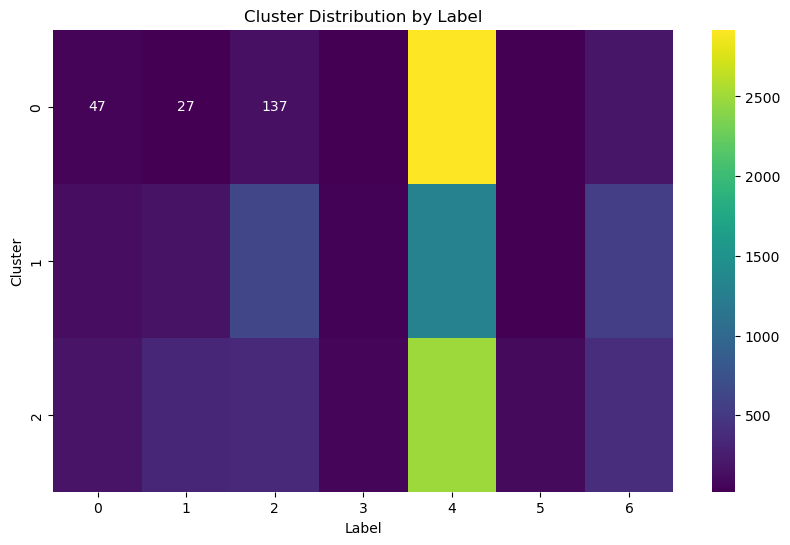

In [9]:
# Example: Explore the cluster distribution by 'label'
clustered_data = images.groupby('cluster')['label'].value_counts().unstack().fillna(0)
print(clustered_data)


# Visualize the cluster distribution for each label
plt.figure(figsize=(10, 6))
sns.heatmap(clustered_data, annot=True, cmap='viridis', fmt='g')
plt.title('Cluster Distribution by Label')
plt.xlabel('Label')
plt.ylabel('Cluster')
plt.show()

C:\Users\sakhi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\sakhi\AppData\Local\Temp\ipykernel_9676\1012756576.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cluster distribution for label 0:
cluster
2    133
1    101
0     93
Name: count, dtype: int64


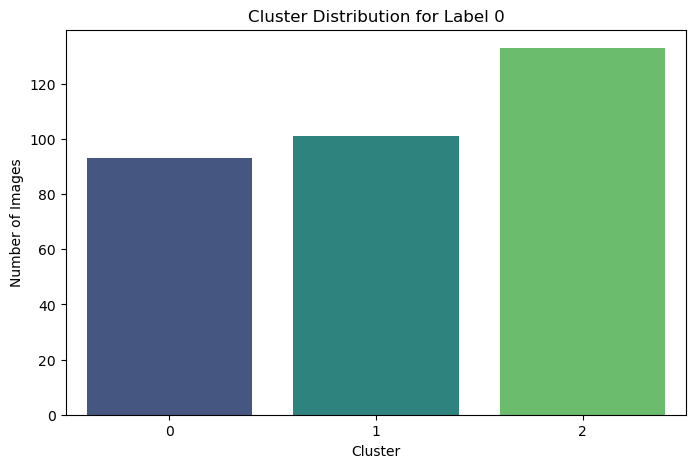

In [10]:
# Process for label 0
label_value = 0
subset = images[images['label'] == label_value]
X = subset.drop(columns=['label'])
X = X / 255.0  # Normalize pixel values

# Apply K-Means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
subset['cluster'] = kmeans.fit_predict(X)

# Check cluster assignment
print(f"Cluster distribution for label {label_value}:")
print(subset['cluster'].value_counts())

# Plot cluster distribution
cluster_distribution = subset['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_distribution.index, y=cluster_distribution.values, palette='viridis')
plt.title(f'Cluster Distribution for Label {label_value}')
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.show()

C:\Users\sakhi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\Users\sakhi\AppData\Local\Temp\ipykernel_9676\3776902855.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cluster distribution for label 1:
cluster
0    209
1    194
2    111
Name: count, dtype: int64


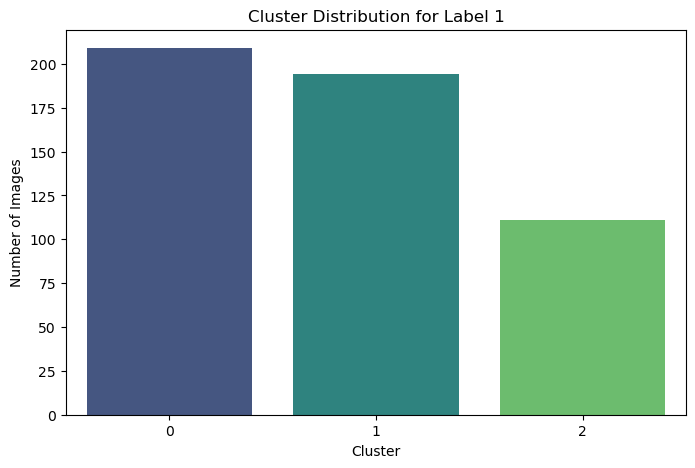

In [11]:
# Process for label 1
label_value = 1
subset = images[images['label'] == label_value]
X = subset.drop(columns=['label'])
X = X / 255.0  # Normalize pixel values

# Apply K-Means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
subset['cluster'] = kmeans.fit_predict(X)

# Check cluster assignment
print(f"Cluster distribution for label {label_value}:")
print(subset['cluster'].value_counts())

# Plot cluster distribution
cluster_distribution = subset['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_distribution.index, y=cluster_distribution.values, palette='viridis')
plt.title(f'Cluster Distribution for Label {label_value}')
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.show()

C:\Users\sakhi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\sakhi\AppData\Local\Temp\ipykernel_9676\3610438833.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cluster distribution for label 2:
cluster
0    393
2    359
1    347
Name: count, dtype: int64


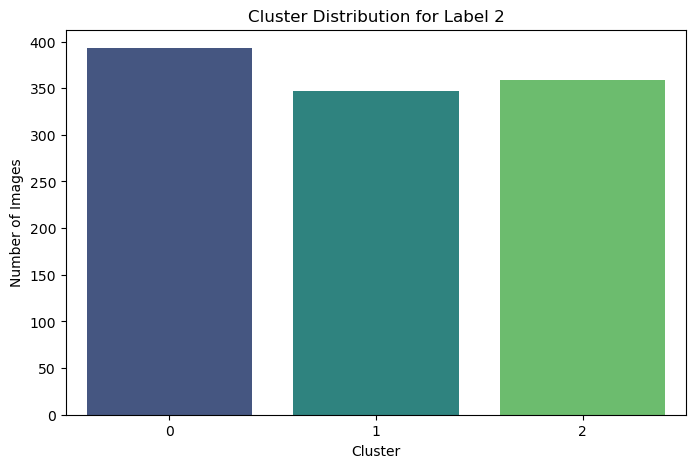

In [12]:
# Process for label 2
label_value = 2
subset = images[images['label'] == label_value]
X = subset.drop(columns=['label'])
X = X / 255.0  # Normalize pixel values

# Apply K-Means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
subset['cluster'] = kmeans.fit_predict(X)

# Check cluster assignment
print(f"Cluster distribution for label {label_value}:")
print(subset['cluster'].value_counts())

# Plot cluster distribution
cluster_distribution = subset['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_distribution.index, y=cluster_distribution.values, palette='viridis')
plt.title(f'Cluster Distribution for Label {label_value}')
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.show()

Cluster distribution for label 3:
cluster
1    51
0    42
2    22
Name: count, dtype: int64


C:\Users\sakhi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\sakhi\AppData\Local\Temp\ipykernel_9676\944783720.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



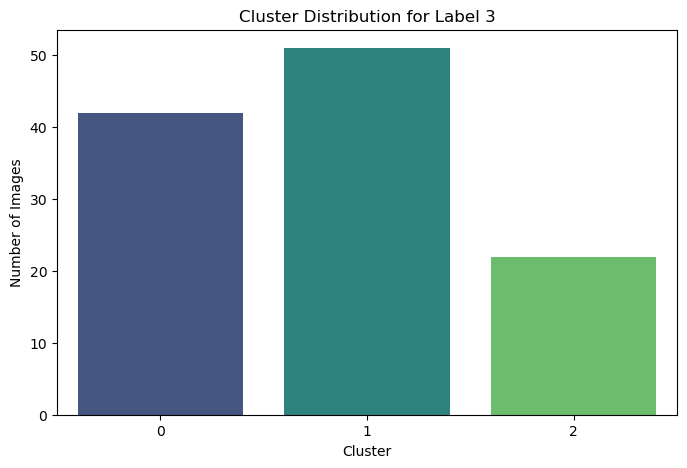

In [13]:
# Process for label 3
label_value = 3
subset = images[images['label'] == label_value]
X = subset.drop(columns=['label'])
X = X / 255.0  # Normalize pixel values

# Apply K-Means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
subset['cluster'] = kmeans.fit_predict(X)

# Check cluster assignment
print(f"Cluster distribution for label {label_value}:")
print(subset['cluster'].value_counts())

# Plot cluster distribution
cluster_distribution = subset['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_distribution.index, y=cluster_distribution.values, palette='viridis')
plt.title(f'Cluster Distribution for Label {label_value}')
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.show()

C:\Users\sakhi\AppData\Local\Temp\ipykernel_9676\3439671989.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cluster distribution for label 4:
cluster
0    2722
2    2600
1    1383
Name: count, dtype: int64


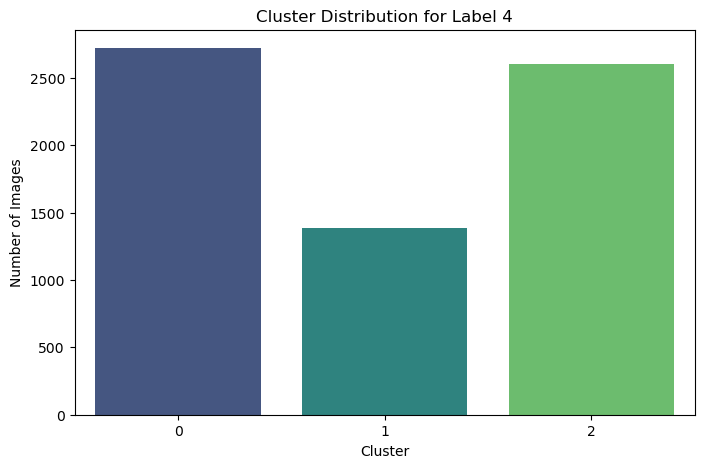

In [14]:
# Process for label 4
label_value = 4
subset = images[images['label'] == label_value]
X = subset.drop(columns=['label'])
X = X / 255.0  # Normalize pixel values

# Apply K-Means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
subset['cluster'] = kmeans.fit_predict(X)

# Check cluster assignment
print(f"Cluster distribution for label {label_value}:")
print(subset['cluster'].value_counts())

# Plot cluster distribution
cluster_distribution = subset['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_distribution.index, y=cluster_distribution.values, palette='viridis')
plt.title(f'Cluster Distribution for Label {label_value}')
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.show()

Cluster distribution for label 5:
cluster
0    77
1    44
2    21
Name: count, dtype: int64


C:\Users\sakhi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\sakhi\AppData\Local\Temp\ipykernel_9676\1176972157.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



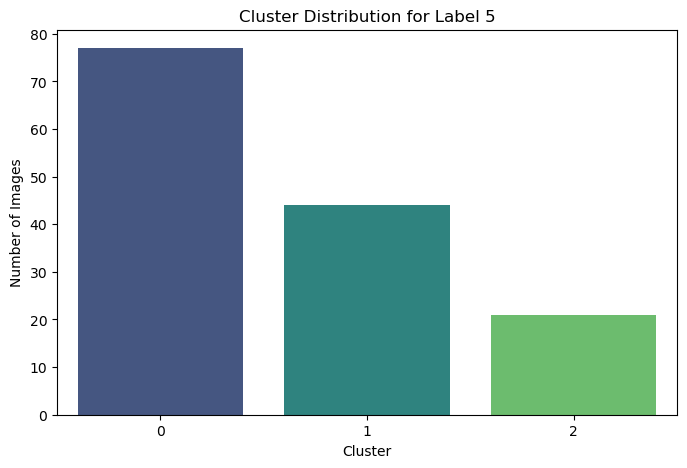

In [15]:
# Process for label 5
label_value = 5
subset = images[images['label'] == label_value]
X = subset.drop(columns=['label'])
X = X / 255.0  # Normalize pixel values

# Apply K-Means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
subset['cluster'] = kmeans.fit_predict(X)

# Check cluster assignment
print(f"Cluster distribution for label {label_value}:")
print(subset['cluster'].value_counts())

# Plot cluster distribution
cluster_distribution = subset['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_distribution.index, y=cluster_distribution.values, palette='viridis')
plt.title(f'Cluster Distribution for Label {label_value}')
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.show()

C:\Users\sakhi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\sakhi\AppData\Local\Temp\ipykernel_9676\452143525.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cluster distribution for label 6:
cluster
0    400
1    397
2    316
Name: count, dtype: int64


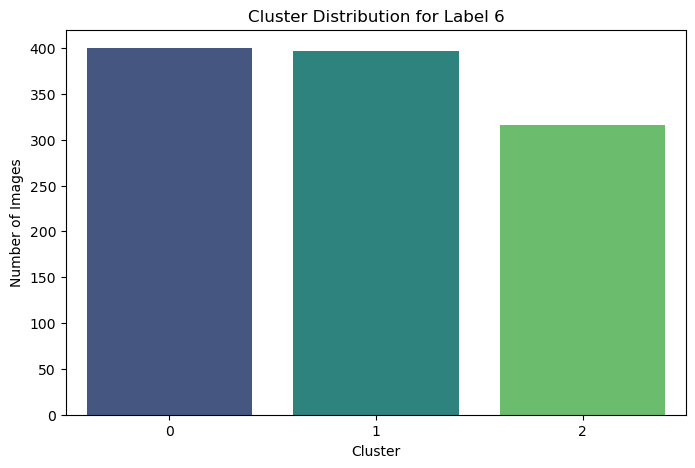

In [16]:
# Process for label 6
label_value = 6
subset = images[images['label'] == label_value]
X = subset.drop(columns=['label'])
X = X / 255.0  # Normalize pixel values

# Apply K-Means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
subset['cluster'] = kmeans.fit_predict(X)

# Check cluster assignment
print(f"Cluster distribution for label {label_value}:")
print(subset['cluster'].value_counts())

# Plot cluster distribution
cluster_distribution = subset['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_distribution.index, y=cluster_distribution.values, palette='viridis')
plt.title(f'Cluster Distribution for Label {label_value}')
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.show()

In [17]:
# Define the dictionary for mapping abbreviations to full names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


# Display the first few rows of the metadata DataFrame
metadata.head()

# Convert abbreviations in the 'dx' column to full names
metadata['lesion_type'] = metadata['dx'].map(lesion_type_dict)

# Display the updated metadata DataFrame
metadata.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                     lesion_type  
0  Benign keratosis-like lesions  
1  Benign keratosis-like lesions  
2  Benign keratosis-like lesions  
3  Benign keratosis-like lesions  
4  Benign keratosis-like lesions

In [18]:
#Check the missing values if any
missing_values = metadata[metadata['dx'].isna()]
print(missing_values)


Empty DataFrame
Columns: [lesion_id, image_id, dx, dx_type, age, sex, localization, lesion_type]
Index: []


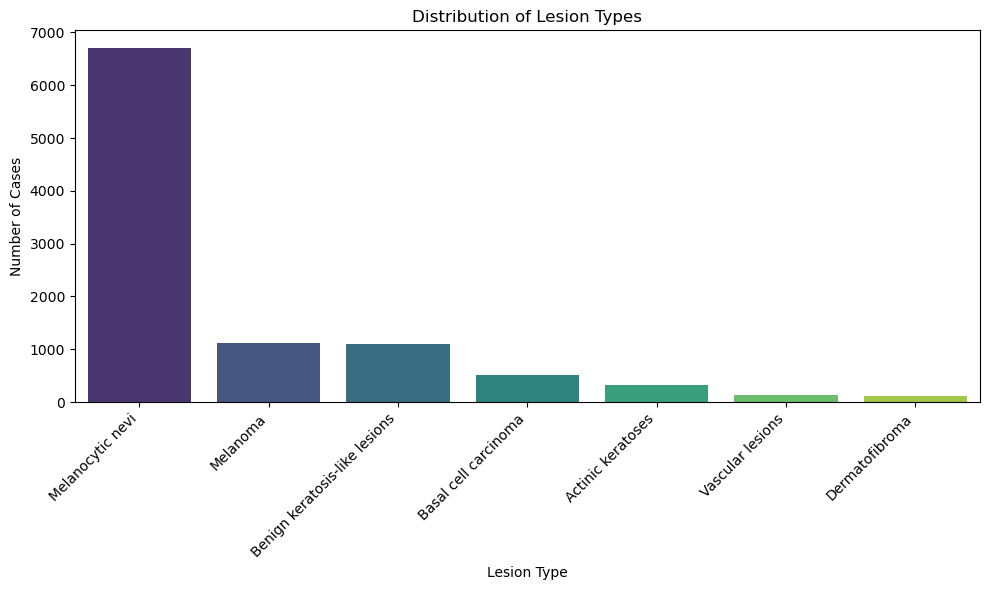

In [19]:
# Count occurrences of each lesion type
lesion_counts = metadata['lesion_type'].value_counts().reset_index()
lesion_counts.columns = ['Lesion Type', 'Number of Cases']

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Lesion Type', y='Number of Cases', data=lesion_counts, palette='viridis')
plt.title('Distribution of Lesion Types')
plt.xlabel('Lesion Type')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

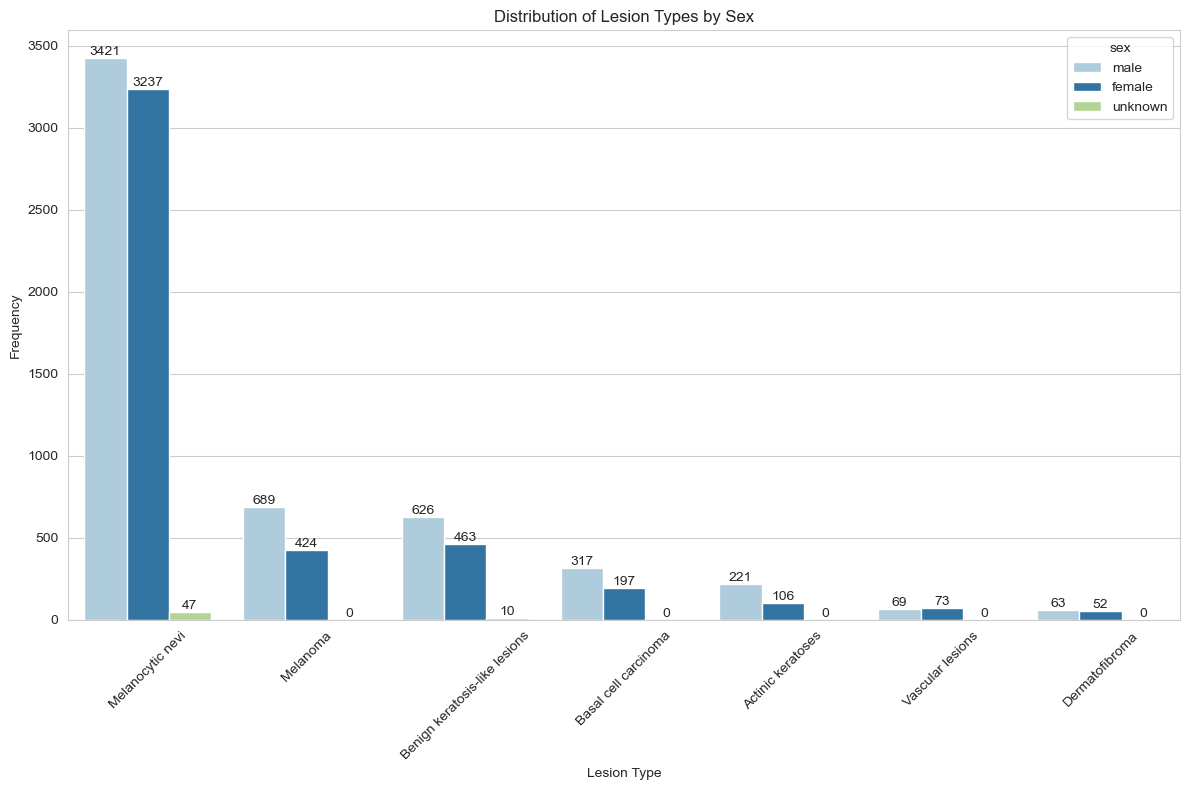

In [20]:
# Set the style of the visualization
sns.set_style("whitegrid")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the count of lesions by sex
sns.countplot(x='lesion_type', hue='sex', data=metadata, palette='Paired', ax=ax, order=metadata['lesion_type'].value_counts().index)

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container)

# Set the title and labels
plt.title('Distribution of Lesion Types by Sex')
plt.xlabel('Lesion Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

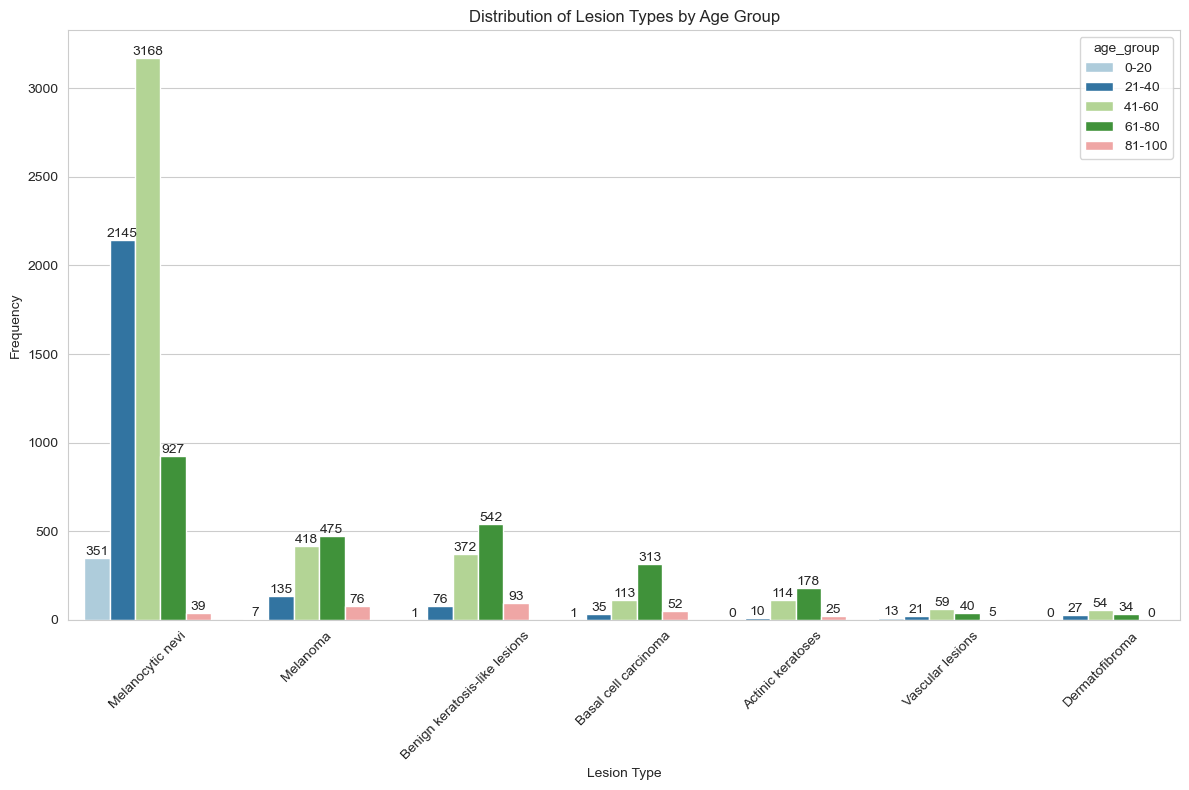

In [21]:
# Set the style of the visualization
sns.set_style("whitegrid")

# Create age groups
age_bins = pd.cut(metadata['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81-100'])
metadata['age_group'] = age_bins

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the count of lesions by age group
sns.countplot(x='lesion_type', hue='age_group', data=metadata, palette='Paired', ax=ax, order=metadata['lesion_type'].value_counts().index)

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container)

# Set the title and labels
plt.title('Distribution of Lesion Types by Age Group')
plt.xlabel('Lesion Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

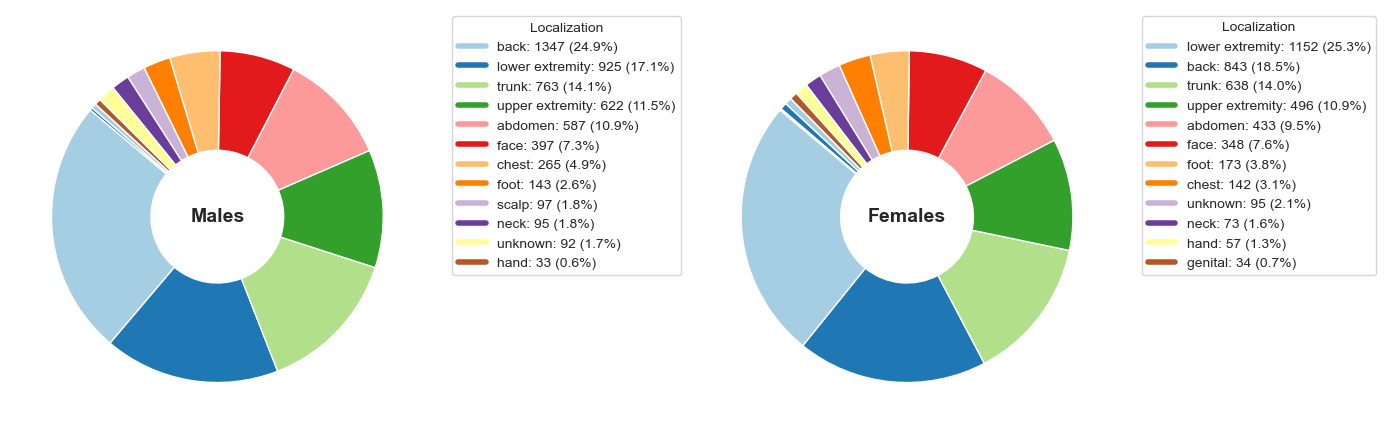

In [22]:
# Set the style of the visualization
sns.set_style("whitegrid")

# Prepare data for donut charts
male_localization = metadata[metadata['sex'] == 'male']['localization'].value_counts()
female_localization = metadata[metadata['sex'] == 'female']['localization'].value_counts()

# Function to create a donut chart
def create_donut_chart(ax, data, title):
    # Create the donut chart
    wedges, texts = ax.pie(
        data,
        colors=sns.color_palette('Paired'),
        startangle=140,
        wedgeprops=dict(width=0.6),  # Width of the donut
        labels=None
    )
    
    # Adding a label to the center of the donut
    ax.text(0, 0, title, ha='center', va='center', fontsize=14, weight='bold')
    
    # Adding a legend outside the donut chart
    legend_labels = [f'{label}: {data[label]} ({data[label]/data.sum()*100:.1f}%)' for label in data.index]
    ax.legend(
        handles=[plt.Line2D([0], [0], color=color, lw=4) for color in sns.color_palette('Paired')],
        labels=legend_labels,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        title='Localization'
    )

# Create figure with two subplots for donut charts
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Donut chart for males
create_donut_chart(axes[0], male_localization, 'Males')

# Donut chart for females
create_donut_chart(axes[1], female_localization, 'Females')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

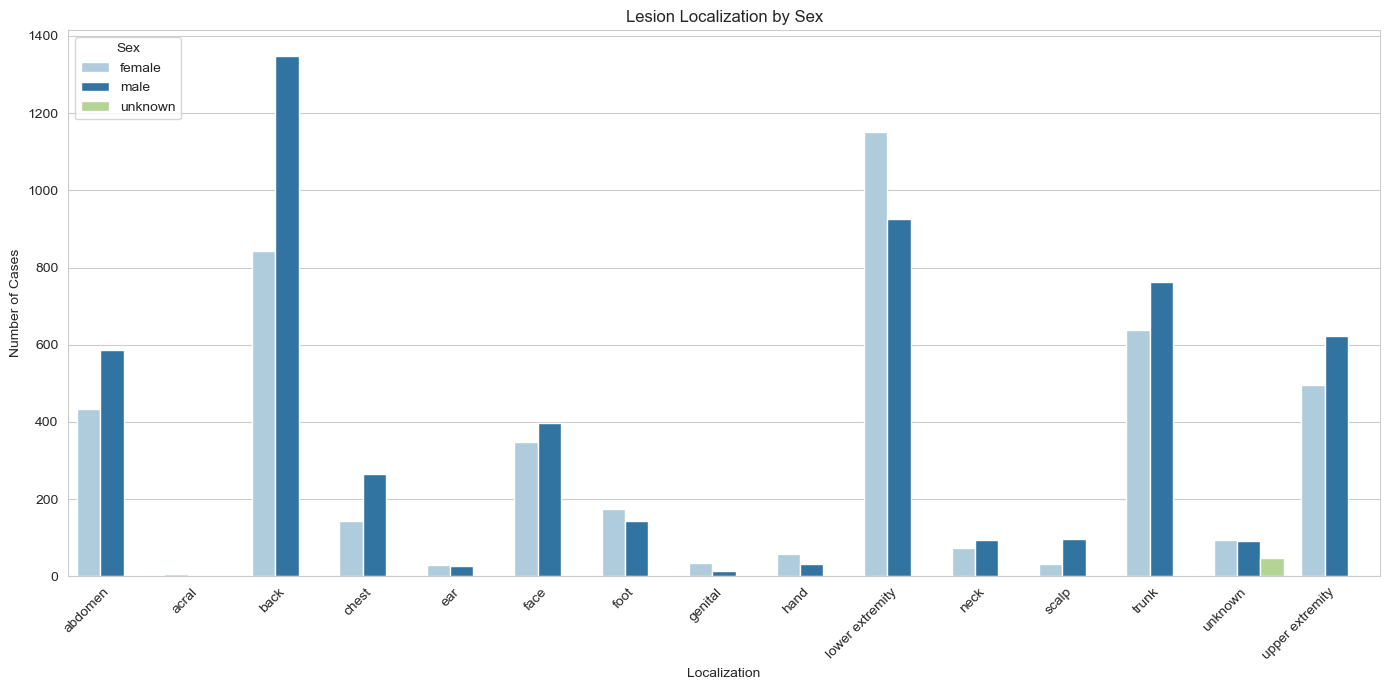

In [23]:
# Set the style of the visualization
sns.set_style("whitegrid")

# Prepare data for bar chart
localization_sex = metadata.groupby(['sex', 'localization']).size().reset_index(name='count')

# Create a bar plot
plt.figure(figsize=(14, 7))
sns.barplot(
    x='localization',
    y='count',
    hue='sex',
    data=localization_sex,
    palette='Paired'
)

plt.title('Lesion Localization by Sex')
plt.xlabel('Localization')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sex')
plt.tight_layout()

# Show the plot
plt.show()

**Model Architecture: Train-Test Split**

In [24]:
# Print column names to verify
print(metadata.columns)


Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'lesion_type', 'age_group'],
      dtype='object')


In [25]:
# Check for missing values
print(metadata.isnull().sum())

# Handle missing values if necessary
metadata.dropna(inplace=True)
# or
# metadata.fillna(method='ffill', inplace=True)

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
lesion_type      0
age_group       96
dtype: int64


In [26]:
# Impute missing age with the median value
median_age = metadata['age'].median()
metadata['age'].fillna(median_age, inplace=True)

# Impute missing age_group with the most frequent value
most_frequent_age_group = metadata['age_group'].mode()[0]
metadata['age_group'].fillna(most_frequent_age_group, inplace=True)

In [27]:
# Verify that there are no more missing values
print(metadata.isnull().sum())

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
lesion_type     0
age_group       0
dtype: int64


**Train-Test Split**

In [28]:
from sklearn.model_selection import train_test_split

# Ensure the correct columns are used
file_paths = metadata['image_id'].values
labels = metadata['lesion_type'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=42)

In [29]:
print(X_train[:5])


['ISIC_0032041' 'ISIC_0028254' 'ISIC_0030428' 'ISIC_0024888'
 'ISIC_0034237']


In [30]:
print(X_test[:5])


['ISIC_0030645' 'ISIC_0033634' 'ISIC_0031739' 'ISIC_0030581'
 'ISIC_0027415']


**Use Scikit-Learn for Image Classification**

In [31]:
import os

# Paths to image directories
directories = [
    "Resources/HAM10000_images_part_1",
    "Resources/HAM10000_images_part_2"
]


# Get all filenames from the image directories
def get_filenames_from_directories(directories):
    filenames = []
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith('.jpg'):
                filenames.append(filename)
    return filenames

files_in_directory = get_filenames_from_directories(directories)


In [32]:
test_limit = 100  # Adjust as needed

# Check for missing files in X_train
missing_files = [filename for filename in X_train[:test_limit] if f'{filename}.jpg' not in files_in_directory]
print("Missing files in X_train:", missing_files)

# Check for missing files in X_test
missing_files_test = [filename for filename in X_test[:test_limit] if f'{filename}.jpg' not in files_in_directory]
print("Missing files in X_test:", missing_files_test)
    

Missing files in X_train: []
Missing files in X_test: []


In [33]:
# Skip missing files in X_train
for filename in X_train[:test_limit]:
    if filename in missing_files:
        print(f"Skipping missing file: {filename}")
        continue
    file_found = False
    for directory in directories:
        full_path = os.path.join(directory, f'{filename}.jpg')
        if os.path.isfile(full_path):
            print(f"Processing: {full_path}")
            file_found = True
            break
    if not file_found:
        print(f"File not found: {filename}")

# Skip missing files in X_test
for filename in X_test[:test_limit]:
    if filename in missing_files_test:
        print(f"Skipping missing file: {filename}")
        continue
    file_found = False
    for directory in directories:
        full_path = os.path.join(directory, f'{filename}.jpg')
        if os.path.isfile(full_path):
            print(f"Processing: {full_path}")
            file_found = True
            break
    if not file_found:
        print(f"File not found: {filename}")


Processing: Resources/HAM10000_images_part_2\ISIC_0032041.jpg
Processing: Resources/HAM10000_images_part_1\ISIC_0028254.jpg
Processing: Resources/HAM10000_images_part_2\ISIC_0030428.jpg
Processing: Resources/HAM10000_images_part_1\ISIC_0024888.jpg
Processing: Resources/HAM10000_images_part_2\ISIC_0034237.jpg
Processing: Resources/HAM10000_images_part_1\ISIC_0024713.jpg
Processing: Resources/HAM10000_images_part_1\ISIC_0027657.jpg
Processing: Resources/HAM10000_images_part_1\ISIC_0028221.jpg
Processing: Resources/HAM10000_images_part_2\ISIC_0031707.jpg
Processing: Resources/HAM10000_images_part_2\ISIC_0031742.jpg
Processing: Resources/HAM10000_images_part_1\ISIC_0026987.jpg
Processing: Resources/HAM10000_images_part_1\ISIC_0027720.jpg
Processing: Resources/HAM10000_images_part_2\ISIC_0032859.jpg
Processing: Resources/HAM10000_images_part_2\ISIC_0032070.jpg
Processing: Resources/HAM10000_images_part_2\ISIC_0031861.jpg
Processing: Resources/HAM10000_images_part_1\ISIC_0026898.jpg
Processi

In [34]:
# Create a dictionary to map filenames to labels
# Assuming 'image_id' is the column with filenames and 'lesion_type' is the column with full labels
label_dict = pd.Series(metadata.lesion_type.values, index=metadata.image_id).to_dict()

# Print some sample entries
print("Sample label_dict entries:", list(label_dict.items())[:10])

Sample label_dict entries: [('ISIC_0027419', 'Benign keratosis-like lesions'), ('ISIC_0025030', 'Benign keratosis-like lesions'), ('ISIC_0026769', 'Benign keratosis-like lesions'), ('ISIC_0025661', 'Benign keratosis-like lesions'), ('ISIC_0031633', 'Benign keratosis-like lesions'), ('ISIC_0027850', 'Benign keratosis-like lesions'), ('ISIC_0029176', 'Benign keratosis-like lesions'), ('ISIC_0029068', 'Benign keratosis-like lesions'), ('ISIC_0025837', 'Benign keratosis-like lesions'), ('ISIC_0025209', 'Benign keratosis-like lesions')]


In [35]:
import os
from PIL import Image
import numpy as np

# Paths to image directories
directories = [
    "Resources/HAM10000_images_part_1",
    "Resources/HAM10000_images_part_2"
]

# Collect all filenames from the image directories
def get_filenames_from_directories(directories):
    filenames = []
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith('.jpg'):
                filenames.append(filename.replace('.jpg', ''))
    return filenames

all_filenames = get_filenames_from_directories(directories)
print("Sample filenames:", all_filenames[:10])

# Preprocess function to load and resize images
def load_image(filepath):
    img = Image.open(filepath)
    img = img.resize((64, 64))  # Resize to 64x64 or any size you prefer
    img_array = np.array(img)   # Convert image to numpy array
    img_array = img_array.flatten() / 255.0  # Flatten and normalize
    return img_array

# Load all images and labels
X_train_images = []
y_train_labels = []

for filename in all_filenames:
    if filename in label_dict:
        # Process the image
        for directory in directories:
            full_path = os.path.join(directory, f'{filename}.jpg')
            if os.path.isfile(full_path):
                img_array = load_image(full_path)
                X_train_images.append(img_array)
                y_train_labels.append(label_dict[filename])
                break  # Exit loop once image is found

# Convert to numpy arrays
X_train_images = np.array(X_train_images)
y_train_labels = np.array(y_train_labels)

print("Processed images shape:", X_train_images.shape)
print("Processed labels shape:", y_train_labels.shape)


Sample filenames: ['ISIC_0024306', 'ISIC_0024307', 'ISIC_0024308', 'ISIC_0024309', 'ISIC_0024310', 'ISIC_0024311', 'ISIC_0024312', 'ISIC_0024313', 'ISIC_0024314', 'ISIC_0024315']
Processed images shape: (9919, 12288)
Processed labels shape: (9919,)


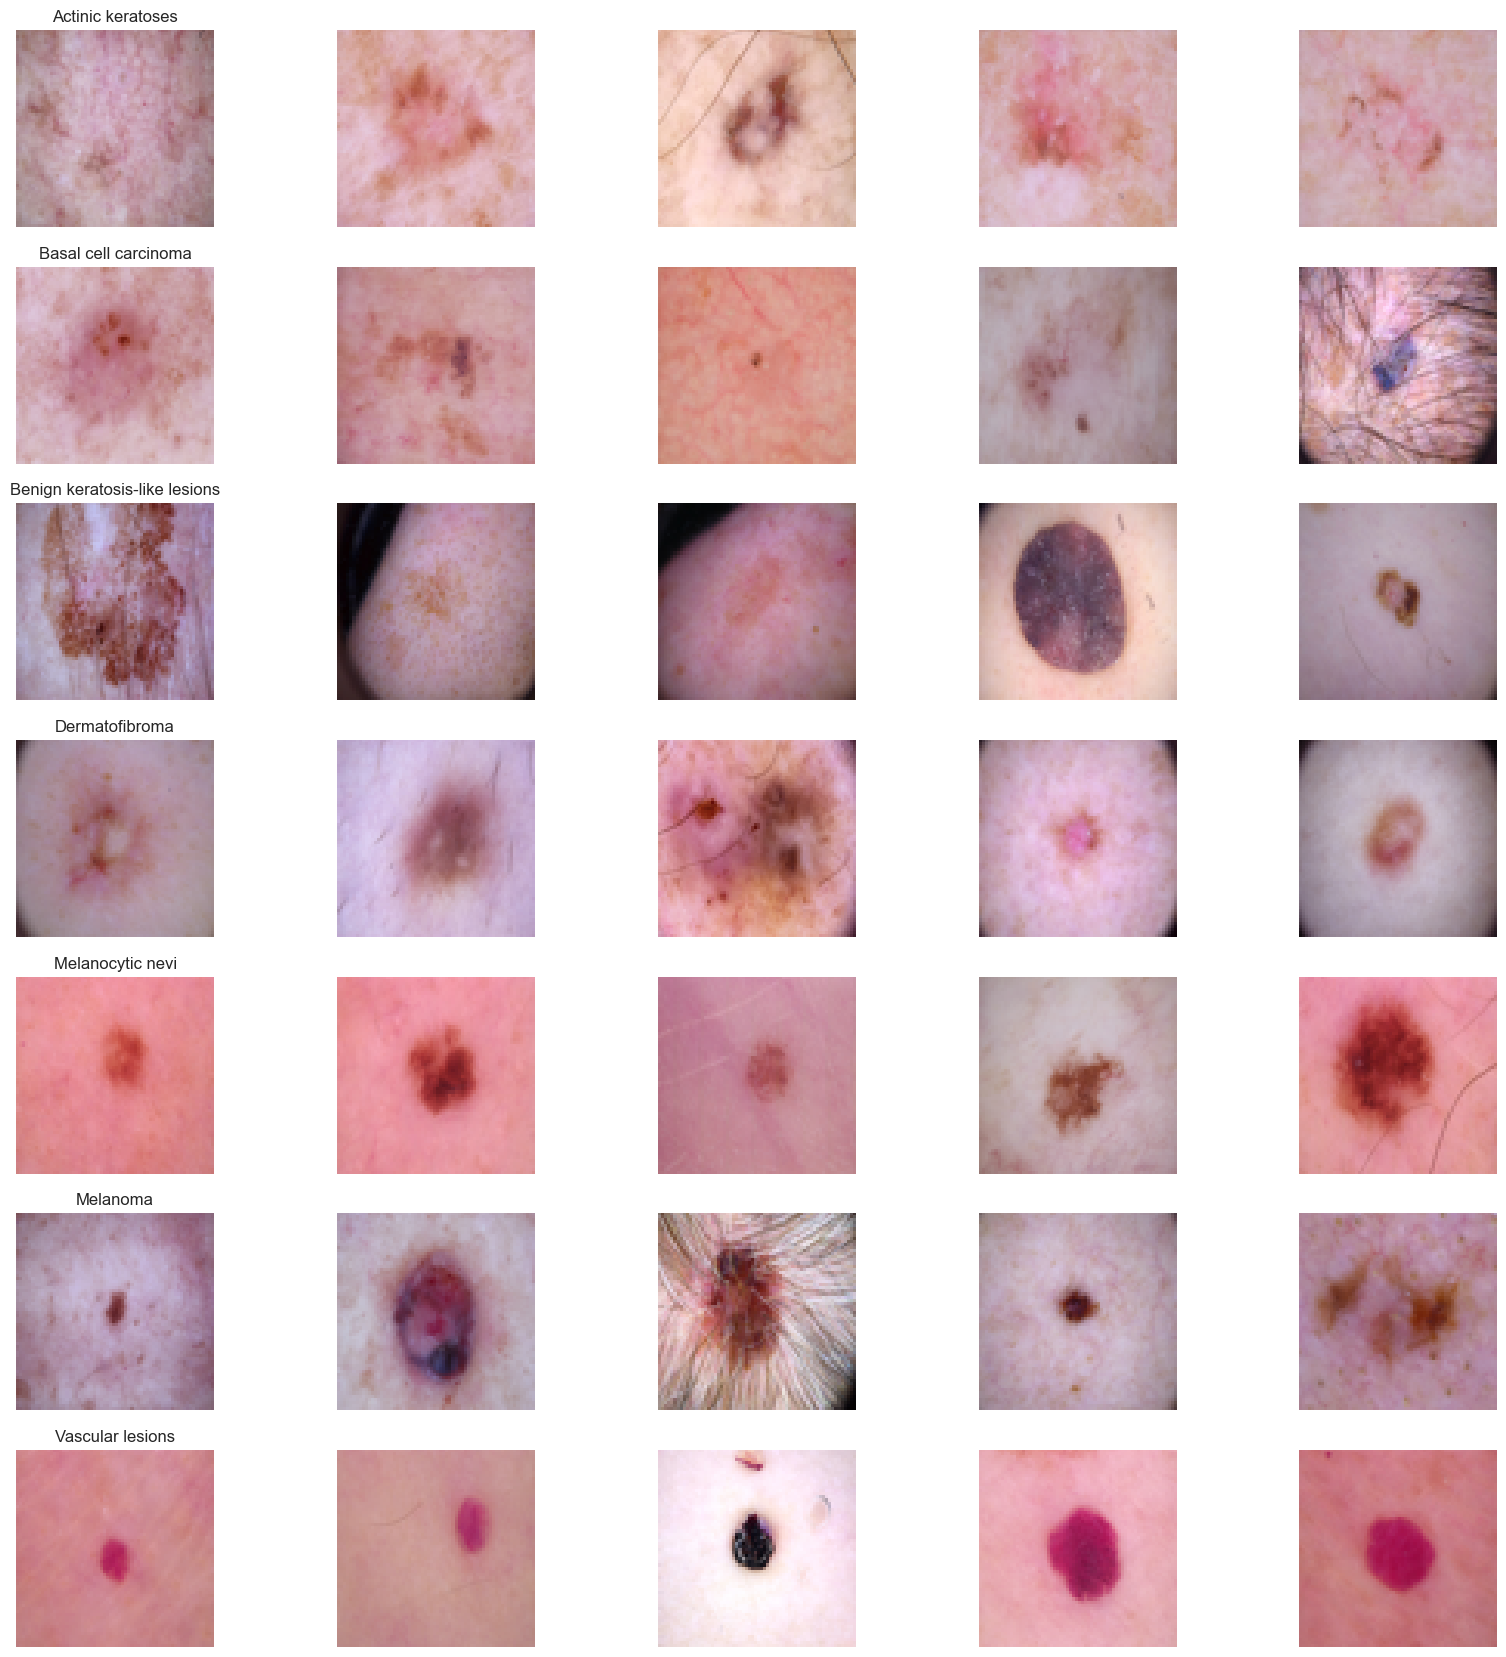

In [36]:
# Import necessary libraries
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor

# Paths to image directories
directories = [
    "Resources/HAM10000_images_part_1",
    "Resources/HAM10000_images_part_2"
]

# Function to load image by filename from directories
def load_image(filename, directories):
    """Load and return an image given its filename and directories to search."""
    for directory in directories:
        image_path = os.path.join(directory, f'{filename}.jpg')
        if os.path.isfile(image_path):
            img = Image.open(image_path)
            img = img.resize((64, 64))  # Resize to speed up display
            return img
    return None

# Now let's sample the images based on lesion types and display them
n_samples = 5  # Number of samples per lesion type
fig, m_axs = plt.subplots(7, n_samples, figsize=(4*n_samples, 3*7))

# Group the metadata DataFrame by lesion type
for n_axs, (lesion_type, lesion_rows) in zip(m_axs, metadata.groupby('lesion_type')):
    n_axs[0].set_title(lesion_type)  # Set the title as the lesion type
    
    # Sample n_samples rows for each lesion type and load the corresponding images
    for c_ax, (_, c_row) in zip(n_axs, lesion_rows.sample(n_samples, random_state=1234).iterrows()):
        img = load_image(c_row['image_id'], directories)  # Use image_id to load the image
        if img is not None:
            c_ax.imshow(img)
        else:
            c_ax.imshow(np.zeros((64, 64, 3)))  # Placeholder if image not found
        c_ax.axis('off')

# Save the figure if needed
fig.savefig('lesion_type_samples.png', dpi=300)

# Display the final figure
plt.show()


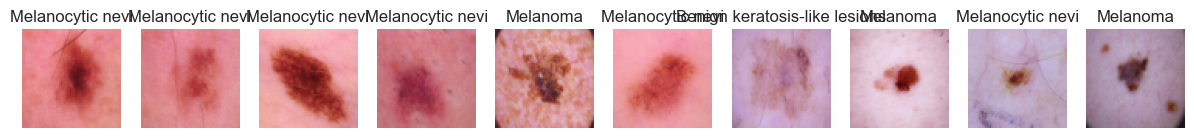

In [37]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor

# Paths to image directories
directories = [
    "Resources/HAM10000_images_part_1",
    "Resources/HAM10000_images_part_2"
]

# Create a dictionary to map filenames to labels (assuming label_dict is already created)

def load_image(filename, directories):
    """Load and return an image given its filename and directories to search."""
    for directory in directories:
        image_path = os.path.join(directory, f'{filename}.jpg')
        if os.path.isfile(image_path):
            img = Image.open(image_path)
            img = img.resize((64, 64))  # Resize to speed up display
            return img
    return None

def display_images(filenames, labels, directories, num_images=5):
    """Display a sample of images with their labels."""
    plt.figure(figsize=(15, 10))

    # Preload images in parallel
    with ThreadPoolExecutor() as executor:
        images = list(executor.map(lambda fname: load_image(fname, directories), filenames[:num_images]))

    for i in range(num_images):
        img = images[i]
        label = labels[i]
        
        plt.subplot(1, num_images, i + 1)
        if img is not None:
            plt.imshow(img)
        else:
            plt.imshow(np.zeros((64, 64, 3)))  # Placeholder if image not found
        plt.title(label)
        plt.axis('off')

    plt.show()

# Display a sample of images
num_images_to_display = 10 
display_images(all_filenames, 
               [label_dict[filename] for filename in all_filenames[:num_images_to_display]],
               directories,
               num_images=num_images_to_display)


In [38]:
import os
from PIL import Image
import numpy as np
import pandas as pd

# Paths to image directories
directories = [
    "Resources/HAM10000_images_part_1",
    "Resources/HAM10000_images_part_2"
]

# Load metadata
metadata_path = "Resources/HAM10000_metadata.csv"
metadata = pd.read_csv(metadata_path)

# Define the dictionary for mapping abbreviations to full names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Convert abbreviations in the 'dx' column to full names
metadata['lesion_type'] = metadata['dx'].map(lesion_type_dict)

# Create a dictionary to map filenames to labels
label_dict = pd.Series(metadata.lesion_type.values, index=metadata.image_id).to_dict()

# Collect all filenames from the image directories
def get_filenames_from_directories(directories):
    filenames = []
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith('.jpg'):
                filenames.append(filename.replace('.jpg', ''))
    return filenames

all_filenames = get_filenames_from_directories(directories)

# Preprocess function to load and resize images
def load_image(filepath):
    img = Image.open(filepath)
    img = img.resize((64, 64))  # Resize to 64x64 or any size you prefer
    img_array = np.array(img)   # Convert image to numpy array
    img_array = img_array.flatten() / 255.0  # Flatten and normalize
    return img_array

# Load all images and labels
X_images = []
y_labels = []

for filename in all_filenames:
    if filename in label_dict:
        for directory in directories:
            full_path = os.path.join(directory, f'{filename}.jpg')
            if os.path.isfile(full_path):
                img_array = load_image(full_path)
                X_images.append(img_array)
                y_labels.append(label_dict[filename])
                break  # Exit loop once image is found

# Convert to numpy arrays
X = np.array(X_images)
y = np.array(y_labels)

print(f"Loaded {X.shape[0]} images.")


Loaded 10015 images.


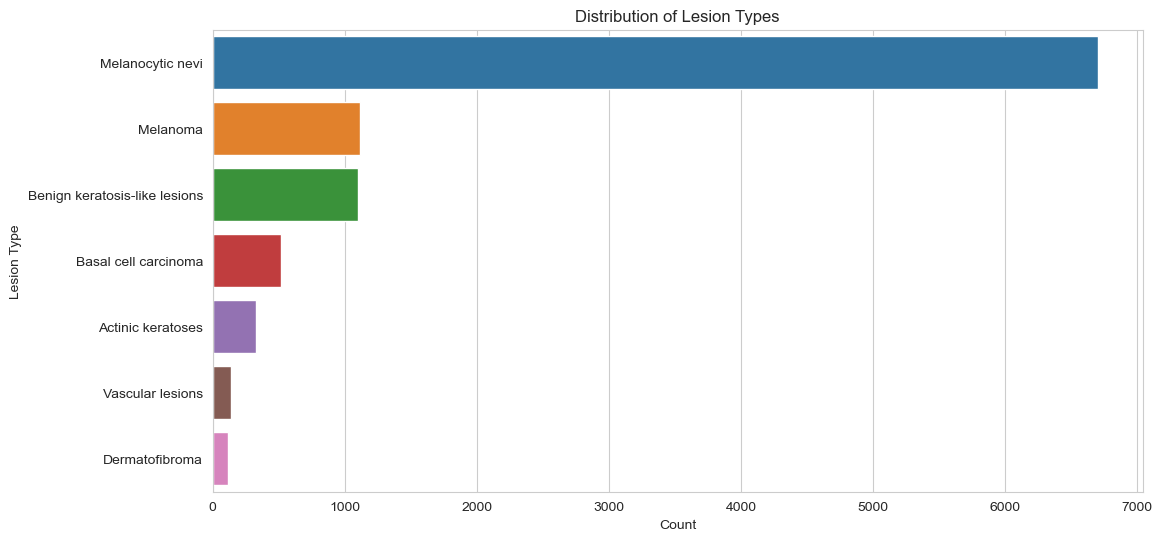

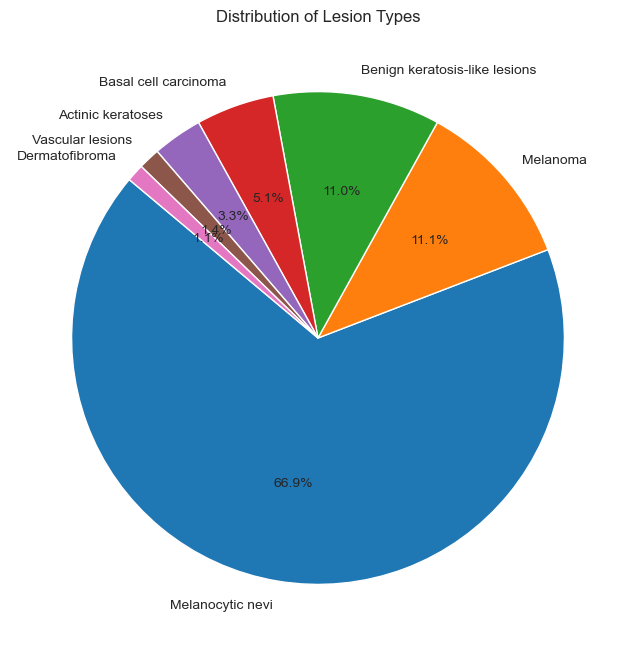

In [39]:

# Plot a bar chart of lesion types
plt.figure(figsize=(12, 6))
sns.countplot(y='lesion_type', data=metadata, order=metadata['lesion_type'].value_counts().index)
plt.title('Distribution of Lesion Types')
plt.xlabel('Count')
plt.ylabel('Lesion Type')
plt.show()

# Plot a pie chart of lesion types
plt.figure(figsize=(8, 8))
lesion_counts = metadata['lesion_type'].value_counts()
plt.pie(lesion_counts, labels=lesion_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Lesion Types')
plt.show()



In [40]:
from sklearn.model_selection import train_test_split

# Normalize the images
X = X / 255.0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (8012, 12288)
Testing data shape: (2003, 12288)


In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Example: Load your image data and labels
# X, y = load_images_and_labels()  # Replace this with your actual data loading function

# Flatten images for SVM input
X_flat = X.reshape(X.shape[0], -1)

# Split data into training and test sets
X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


**Different Classifiers:** Logistic Regression

C:\Users\sakhi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Test accuracy: 0.66


<Figure size 1200x600 with 0 Axes>

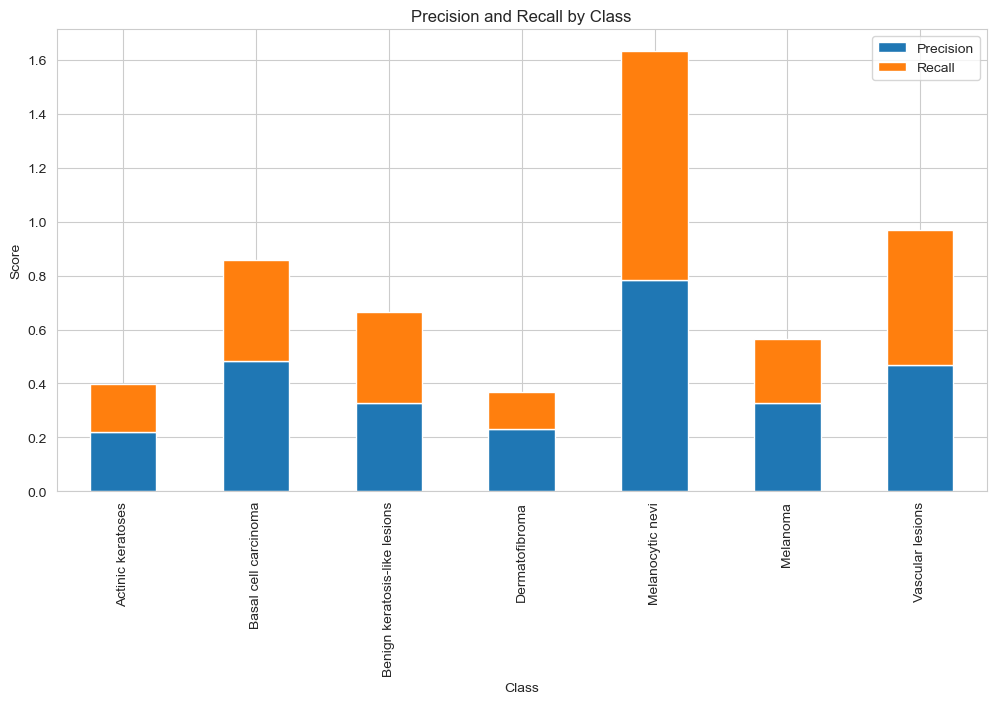

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score


# Ensure that X_train_flat, X_test_flat, y_train_encoded, and y_test_encoded are correctly defined and preprocessed

# Create a pipeline with scaling and Logistic Regression
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# Train the model
model.fit(X_train_flat, y_train_encoded)

# Predict on the test set
y_pred = model.predict(X_test_flat)

# Evaluate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Test accuracy: {accuracy:.2f}")

# Compute precision and recall
precision = precision_score(y_test_encoded, y_pred, average=None, labels=range(len(label_encoder.classes_)))
recall = recall_score(y_test_encoded, y_pred, average=None, labels=range(len(label_encoder.classes_)))

# Create a DataFrame for easy plotting
precision_recall_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall
})

# Plot precision and recall
plt.figure(figsize=(12, 6))
precision_recall_df.plot(x='Class', kind='bar', stacked=True, figsize=(12, 6))
plt.title('Precision and Recall by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.show()

**Different Classifiers:** Random Forest

Test accuracy: 0.71


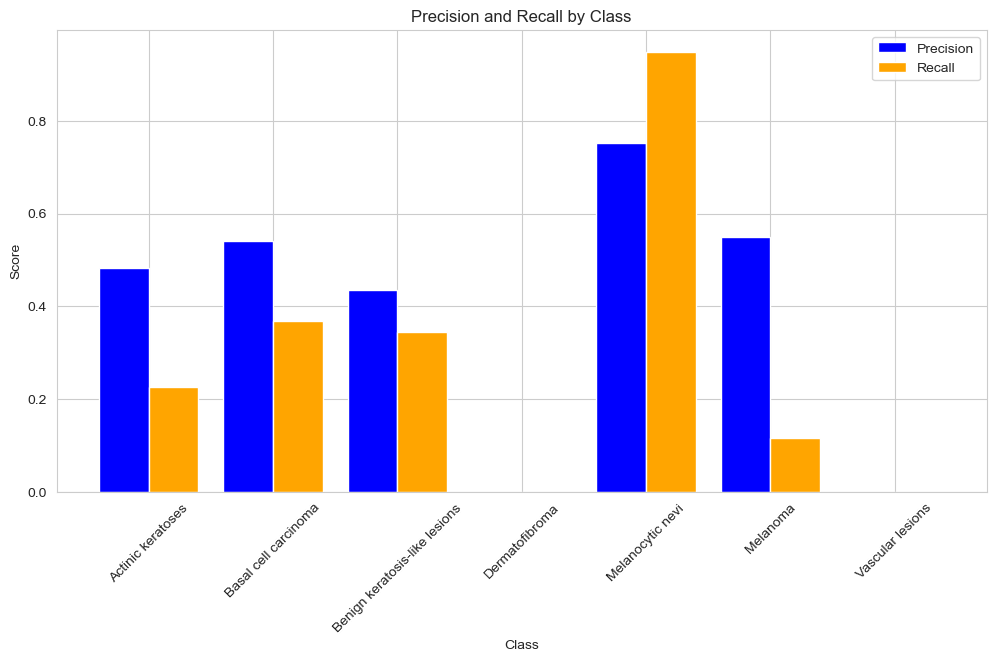

In [43]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Assuming X_train_flat, X_test_flat, y_train_encoded, y_test_encoded, and label_encoder are already defined

# Create a pipeline with scaling and Random Forest
model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100))

# Train the model
model.fit(X_train_flat, y_train_encoded)

# Predict on the test set
y_pred = model.predict(X_test_flat)

# Evaluate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Test accuracy: {accuracy:.2f}")

# Compute precision and recall
precision = precision_score(y_test_encoded, y_pred, average=None, labels=range(len(label_encoder.classes_)), zero_division=0)
recall = recall_score(y_test_encoded, y_pred, average=None, labels=range(len(label_encoder.classes_)), zero_division=0)

# Create a DataFrame for easy plotting
precision_recall_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall
})

# Numeric positions for plotting
positions = range(len(precision_recall_df))

# Plot precision and recall
plt.figure(figsize=(12, 6))

# Plot precision
plt.bar([p - 0.2 for p in positions], precision_recall_df['Precision'], width=0.4, label='Precision', color='blue', align='center')
# Plot recall
plt.bar([p + 0.2 for p in positions], precision_recall_df['Recall'], width=0.4, label='Recall', color='orange', align='center')

plt.title('Precision and Recall by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(ticks=positions, labels=precision_recall_df['Class'], rotation=45)
plt.legend()
plt.show()


**Advance Analysis:**
Dimentionality Reduction For Classification (PCA)

Test accuracy: 0.70


C:\Users\sakhi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



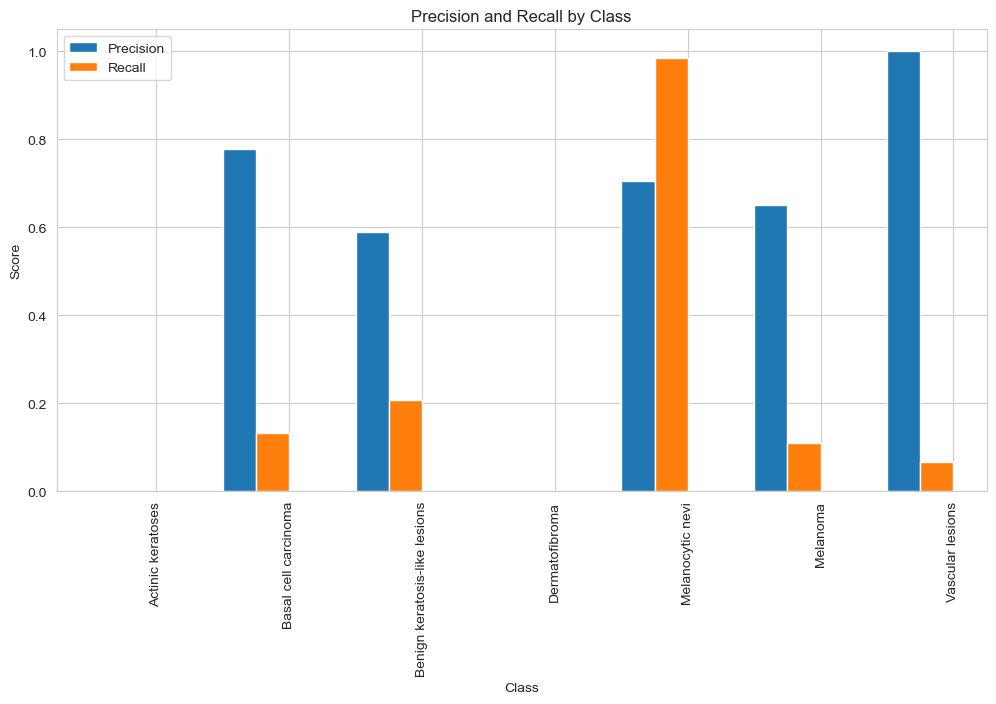

In [44]:
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score

# Reduce dimensions to 100 principal components
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# Train and evaluate the model on PCA-transformed data
model.fit(X_train_pca, y_train_encoded)
y_pred = model.predict(X_test_pca)

# Evaluate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Test accuracy: {accuracy:.2f}")

# Compute precision and recall
precision = precision_score(y_test_encoded, y_pred, average=None, labels=range(len(label_encoder.classes_)))
recall = recall_score(y_test_encoded, y_pred, average=None, labels=range(len(label_encoder.classes_)))

# Create a DataFrame for easy plotting
precision_recall_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall
})

# Plot precision and recall
precision_recall_df.plot(x='Class', kind='bar', figsize=(12, 6), position=1)
plt.title('Precision and Recall by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.show()

**Advance Analysis:**
Dimentionality Reduction For Visualization (PCA)

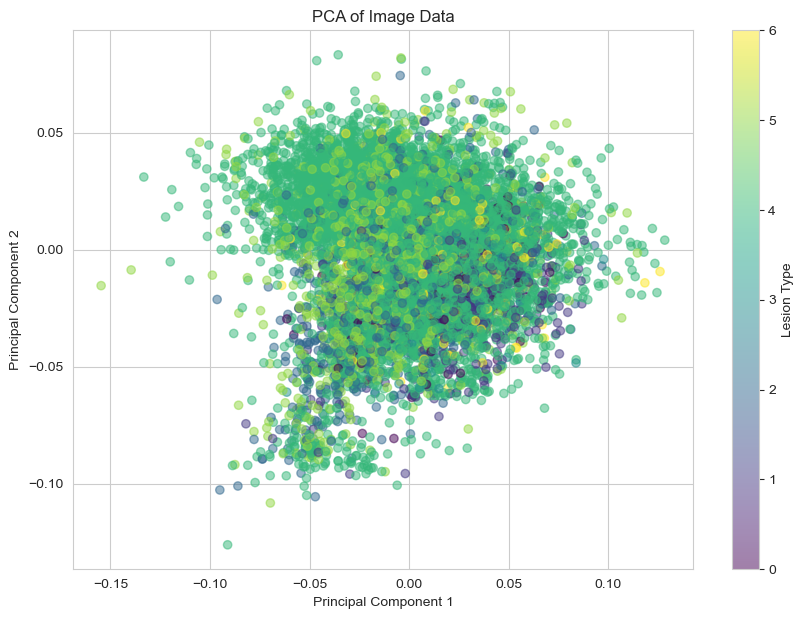

In [45]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


# Assuming X contains image data and y contains labels

# Encode categorical labels into numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Reduce dimensions to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create scatter plot of PCA results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Lesion Type')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Image Data')
plt.show()


**t-SNE Technique** for Dimentionality Reduction 

C:\Users\sakhi\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



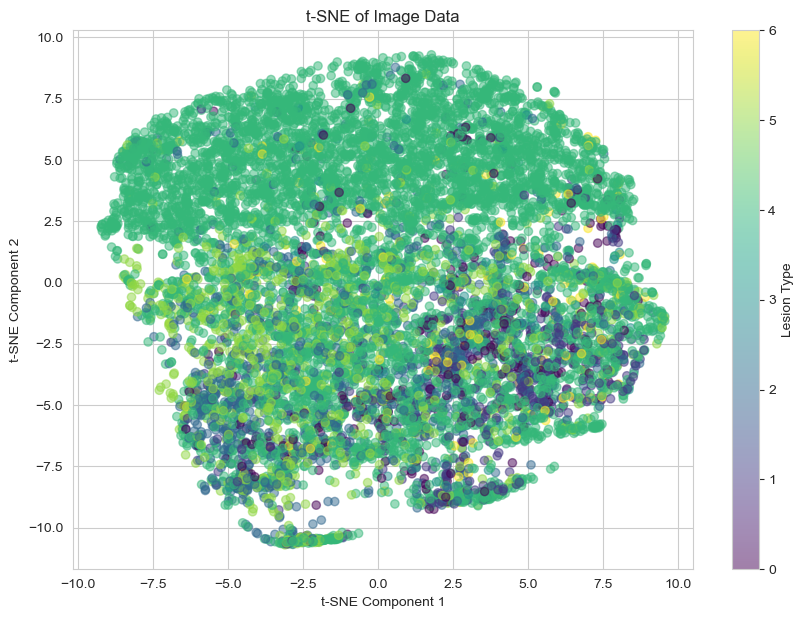

In [46]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X)

# Plot the t-SNE results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Lesion Type')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Image Data')
plt.show()


**Feature Engineering:** Creating Additional Features

In [47]:
def extract_image_features(image_array):
    mean = np.mean(image_array)
    std_dev = np.std(image_array)
    return [mean, std_dev]

# Apply feature extraction
features = [extract_image_features(img) for img in X]
X_features = np.array(features)


**Model Comparison**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Train and evaluate a RandomForest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("RandomForest Classification Report:")
print(classification_report(y_test, rf_predictions))

# Train and evaluate an SVM model
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))


RandomForest Classification Report:
                               precision    recall  f1-score   support

            Actinic keratoses       0.50      0.24      0.33        62
         Basal cell carcinoma       0.56      0.38      0.45       106
Benign keratosis-like lesions       0.44      0.34      0.38       206
               Dermatofibroma       0.00      0.00      0.00        22
             Melanocytic nevi       0.76      0.95      0.84      1338
                     Melanoma       0.58      0.13      0.22       239
             Vascular lesions       0.00      0.00      0.00        30

                     accuracy                           0.71      2003
                    macro avg       0.40      0.29      0.32      2003
                 weighted avg       0.66      0.71      0.66      2003



C:\Users\sakhi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sakhi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sakhi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



**Visualization and Dynamic Dashboard:** Confusion Matrix

In [ ]:
# from sklearn.utils import resample

# # Downsample y_test and predictions
# y_test_sample, rf_predictions_sample = resample(y_test, rf_predictions, n_samples=500, random_state=42)

# # Compute confusion matrix on the sample
# cm = confusion_matrix(y_test_sample, rf_predictions_sample, labels=model.classes_)

# # Display confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# disp.plot(cmap='viridis')
# plt.title('Confusion Matrix (Sampled Data)')
# plt.show()

**Visualization and Dynamic Dashboard:** Interactive Dashboard

In [ ]:
# import plotly.express as px

# # Example visualization of image classifications
# fig = px.scatter(X_tsne, x=0, y=1, color=y, labels={'color': 'Lesion Type'})
# fig.update_layout(title='t-SNE Visualization of Image Data')
# fig.show()


**Pre_Trained Models**

In [ ]:
# from keras.applications import MobileNetV2
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D
# from keras.optimizers import Adam

# # Load MobileNetV2 with pre-trained weights and exclude top layers
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Add custom layers on top of the base model
# x = base_model.output
# x = GlobalAveragePooling2D()(x)  # Global average pooling layer
# x = Dense(512, activation='relu')(x)  # Reduced the number of units here to make it faster
# predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  # Output layer with the number of classes

# # Define the model
# model = Model(inputs=base_model.input, outputs=predictions)

# # Compile the model
# model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train and evaluate the model
# history = model.fit(X_train, y_train_encoded, epochs=5, batch_size=16, validation_split=0.2)  # Fewer epochs and smaller batch size
# accuracy = history.history['val_accuracy'][-1]
# print(f"Validation accuracy: {accuracy:.2f}")


**NOTE** these last 3 codes took lots of time to run as our files are too large. they are not that essential. if they run in your desktop then we can keep them otherwies we will delete them. pls let me know to your thoughts. 